In [1]:
import os
import sys
from collections import defaultdict, Counter
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import ete3
from ete3 import PhyloTree
from Bio import SeqIO

In [2]:
import pymutspec
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.annotation.spectra import complete_sbs192_columns, get_cossim
from pymutspec.io import read_rates 

## get exp sbs freqs

In [3]:
coda = CodonAnnotation(2)

In [4]:
rates = read_rates(    '../data/nemu_output_compsp/IQTREE/anc.rate')
site2rates = dict(enumerate(rates, 1))
msa = list(SeqIO.parse('../data/nemu_output_compsp/sequences/alignment_checked.fasta', 'fasta'))
id2names = pd.read_csv('../data/nemu_output_compsp/sequences/species_mapping.txt', 
                       sep='\t', index_col=0, header=None,)[1].to_dict()
for rec in msa:
    rec.name = rec.id = rec.description = id2names[rec.id]

In [5]:
assert len(rates) == len(msa[0])

In [6]:
# distribution of ratecats in CYTB gene
pd.Series(rates).value_counts().sort_index()

0    212
1    244
2    128
3     85
4     93
5    174
6    201
dtype: int64

In [7]:
# same, but in percents
pd.Series(rates).value_counts(normalize=True).sort_index().round(4) * 100

0    18.65
1    21.46
2    11.26
3     7.48
4     8.18
5    15.30
6    17.68
dtype: float64

In [8]:
exp_lst = []
for rec in msa:
    exp_lst.append(
        coda.collect_exp_muts(str(rec.seq)).assign(species=rec.name)
    )
exp = pd.concat(exp_lst).rename(columns={'Pos': 'Site'})
exp['rate'] = exp.Site.map(site2rates)

In [9]:
exp.groupby(['species']).rate.value_counts().unstack().fillna(0).mean(0)

rate
0      0.015400
1      1.162218
2      0.422998
3      6.986653
4     51.211499
5    212.784394
6    540.454825
dtype: float64

<AxesSubplot:xlabel='rate', ylabel='exp sbs count'>

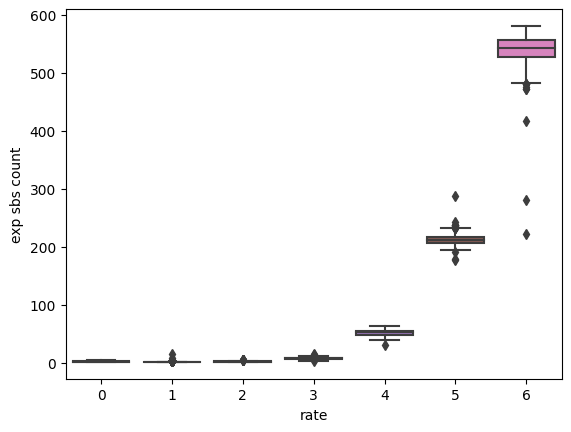

In [10]:
sns.boxplot(data=exp.groupby(['species']).rate.value_counts().rename('exp sbs count').reset_index(), 
            x='rate', y='exp sbs count')

In [11]:
exp

,Site,Pic,Mut,Cdn,Label,species,rate
0,3,3,T[G>A]T,ATG,syn,Branchiostoma_floridae outgroup,1
1,6,3,C[T>G]G,TCT,syn,Branchiostoma_floridae outgroup,4
2,6,3,C[T>A]G,TCT,syn,Branchiostoma_floridae outgroup,4
3,6,3,C[T>C]G,TCT,syn,Branchiostoma_floridae outgroup,4
4,9,3,G[T>G]T,GGT,syn,Branchiostoma_floridae outgroup,4
...,...,...,...,...,...,...,...
801,1129,1,C[C>T]T,CTA,syn,Micropteropus_pusillus,4
802,1131,3,T[A>T]A,CTA,syn,Micropteropus_pusillus,5
803,1131,3,T[A>C]A,CTA,syn,Micropteropus_pusillus,5
804,1131,3,T[A>G]A,CTA,syn,Micropteropus_pusillus,5


In [12]:
exp_rate_freqs = complete_sbs192_columns(
    exp[exp.rate > 3].groupby(['species', 'rate']).Mut.value_counts().unstack().fillna(0))
exp_rate_freqs

Mut                            A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  C[A>C]A  \
species                  rate                                                
Abbottina_obtusirostris  4         0.0      0.0      0.0      0.0      1.0   
                         5         0.0      0.0      0.0      0.0      0.0   
                         6         0.0      0.0      0.0      0.0     10.0   
Abbottina_rivularis      4         0.0      0.0      0.0      0.0      1.0   
                         5         0.0      0.0      0.0      0.0      0.0   
...                                ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5         0.0      0.0      0.0      0.0      2.0   
                         6         0.0      0.0      0.0      0.0      7.0   
Zosterops_japonicus      4         0.0      0.0      0.0      0.0      0.0   
                         5         0.0      0.0      0.0      0.0      2.0   
                         6         0.0      0.0      0.0      0.0      7.0   

Mut                            C[A>C]C  C[A>C]G  C[A>C]T  G[A>C]A  G[A>C]C  \
species                  rate                                                
Abbottina_obtusirostris  4         0.0      0.0      0.0      0.0      0.0   
                         5         3.0      1.0      2.0      1.0      1.0   
                         6         9.0     11.0     15.0      0.0      0.0   
Abbottina_rivularis      4         0.0      0.0      0.0      0.0      0.0   
                         5         2.0      1.0      2.0      1.0      1.0   
...                                ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5         1.0      1.0      3.0      1.0      0.0   
                         6        10.0     11.0     10.0      0.0      2.0   
Zosterops_japonicus      4         0.0      0.0      0.0      0.0      0.0   
                         5         1.0      1.0      3.0      1.0      0.0   
                         6        10.0     10.0     10.0      0.0      3.0   

Mut                            ...  C[T>G]G  C[T>G]T  G[T>G]A  G[T>G]C  \
species                  rate  ...                                       
Abbottina_obtusirostris  4     ...      0.0      0.0      0.0      0.0   
                         5     ...      0.0      0.0      0.0      0.0   
                         6     ...      3.0      0.0      1.0      0.0   
Abbottina_rivularis      4     ...      0.0      0.0      0.0      0.0   
                         5     ...      0.0      1.0      0.0      0.0   
...                            ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5     ...      0.0      2.0      1.0      0.0   
                         6     ...      2.0      2.0      0.0      0.0   
Zosterops_japonicus      4     ...      0.0      0.0      0.0      0.0   
                         5     ...      0.0      2.0      1.0      0.0   
                         6     ...      3.0      6.0      0.0      1.0   

Mut                            G[T>G]G  G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  \
species                  rate                                                
Abbottina_obtusirostris  4         0.0      0.0      0.0      0.0      1.0   
                         5         1.0      0.0      1.0      0.0      0.0   
                         6         2.0      2.0      2.0      8.0      5.0   
Abbottina_rivularis      4         0.0      0.0      0.0      0.0      0.0   
                         5         1.0      0.0      0.0      0.0      0.0   
...                                ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5         0.0      1.0      0.0      1.0      0.0   
                         6         1.0      0.0      1.0      5.0      2.0   
Zosterops_japonicus      4         0.0      0.0      0.0      0.0      0.0   
                         5         0.0      1.0      0.0      1.0      0.0   
                         6         1.0      0.0      1.0      4.0      

In [13]:
css = []
for sp in exp_rate_freqs.index.get_level_values(0).unique():
    df = exp_rate_freqs.loc[sp]
    cossim = 1 - pdist(df, 'cosine')
    css.append(cossim)

In [14]:
# 4vs5, 4vs6, 5vs6
np.array(css).mean(0)

array([0.55384259, 0.21537597, 0.43302234])

In [15]:
exp_rate_freqs.astype(int).to_csv('../data/exp_sbs_freqs_light_strand.csv')

## compare new exp freqs with old ones

In [16]:
spectra = pd.read_csv('../data/MutSpecVertebratescytb.csv')
spectra

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.000000,T>C,TTT,Actinopterygii
...,...,...,...,...,...,...,...,...,...,...
185659,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.0,15.981840,0.062571,A>G,AAA,Aves
185660,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.0,15.981840,0.000000,A>C,TAA,Aves
185661,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.0,15.981840,0.000000,A>C,GAA,Aves
185662,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.0,15.981840,0.000000,A>C,CAA,Aves


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


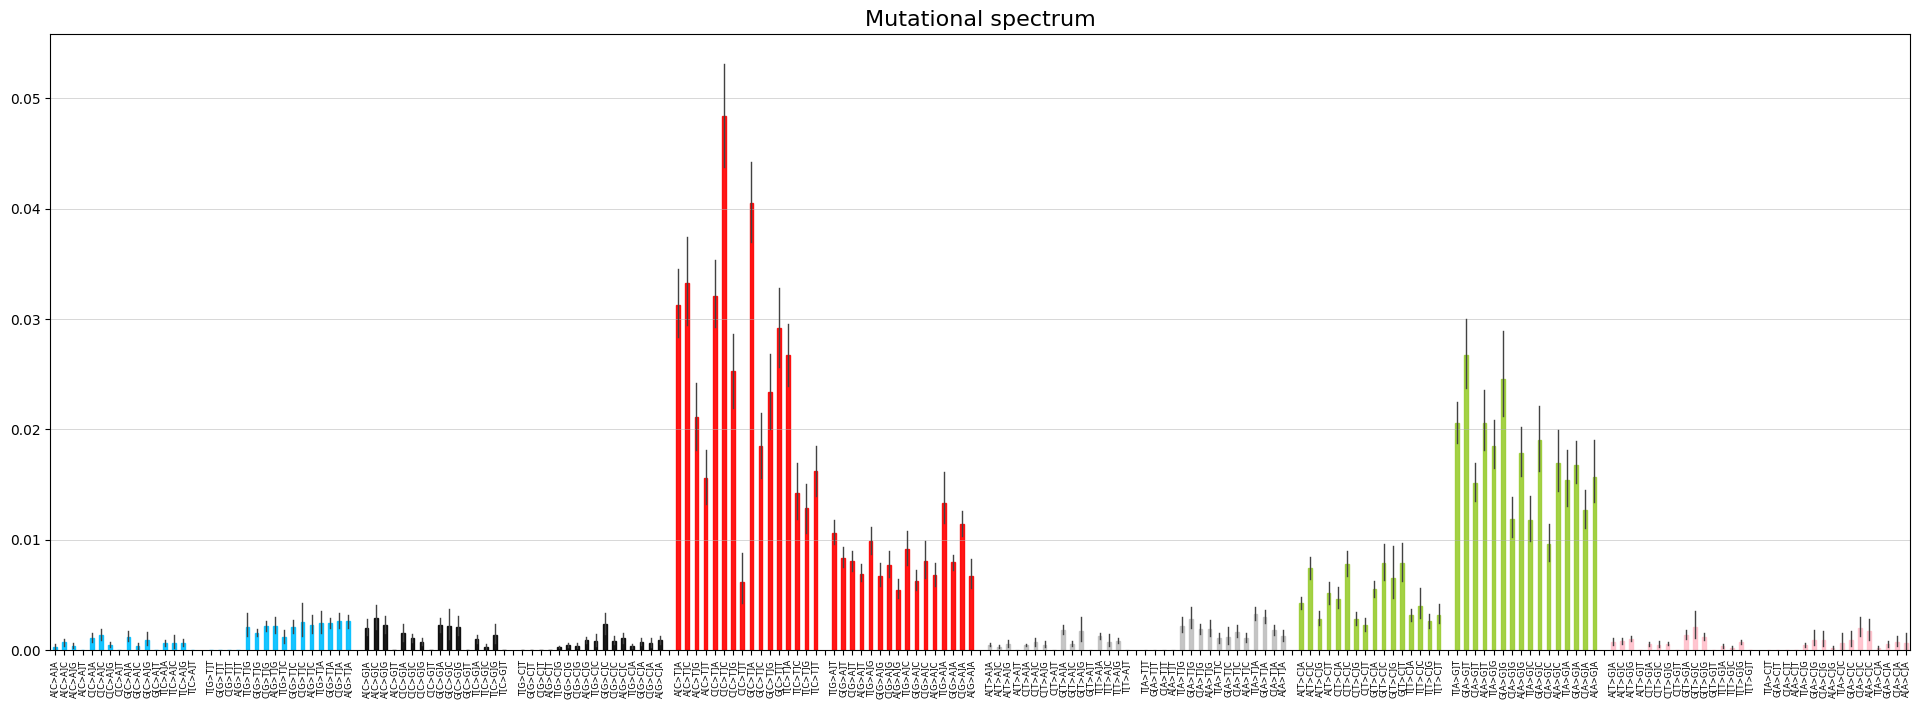

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [17]:
pymutspec.draw.plot_mutspec192(spectra)

In [18]:
exp_rate_freqs_long = exp_rate_freqs.stack().rename('exp_new').reset_index()
exp_rate_freqs_456_h = exp_rate_freqs_long.groupby(['species', 'Mut'])\
    .exp_new.sum().rename('exp_new456').reset_index()
exp_rate_freqs_56_h = exp_rate_freqs_long[exp_rate_freqs_long.rate > 4]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new56').reset_index()
exp_rate_freqs_6_h = exp_rate_freqs_long[exp_rate_freqs_long.rate == 6]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new6').reset_index()
exp_rate_freqs_5_h = exp_rate_freqs_long[exp_rate_freqs_long.rate == 5]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new5').reset_index()
exp_rate_freqs_4_h = exp_rate_freqs_long[exp_rate_freqs_long.rate == 4]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new4').reset_index()

exp_rate_freqs_456_h['Mut'] = exp_rate_freqs_456_h['Mut'].apply(rev_comp)
exp_rate_freqs_56_h['Mut']  =  exp_rate_freqs_56_h['Mut'].apply(rev_comp)
exp_rate_freqs_6_h['Mut']   =   exp_rate_freqs_6_h['Mut'].apply(rev_comp)
exp_rate_freqs_5_h['Mut']   =   exp_rate_freqs_5_h['Mut'].apply(rev_comp)
exp_rate_freqs_4_h['Mut']   =   exp_rate_freqs_4_h['Mut'].apply(rev_comp)

In [19]:
exp_rate_freqs_h = exp_rate_freqs_456_h.merge(exp_rate_freqs_56_h, on=['species', 'Mut'])\
    .merge(exp_rate_freqs_6_h, on=['species', 'Mut'])\
        .merge(exp_rate_freqs_5_h, on=['species', 'Mut'])\
            .merge(exp_rate_freqs_4_h, on=['species', 'Mut'])

In [20]:
exp_rate_freqs_h

,species,Mut,exp_new456,exp_new56,exp_new6,exp_new5,exp_new4
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,0.0,0.0
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,0.0,0.0
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,0.0,0.0
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,0.0,0.0
4,Abbottina_obtusirostris,T[T>C]T,7.0,3.0,0.0,3.0,4.0
...,...,...,...,...,...,...,...
187003,Zosterops_japonicus,A[A>G]A,3.0,2.0,1.0,1.0,1.0
187004,Zosterops_japonicus,T[A>C]A,1.0,1.0,1.0,0.0,0.0
187005,Zosterops_japonicus,G[A>C]A,5.0,5.0,4.0,1.0,0.0
187006,Zosterops_japonicus,C[A>C]A,4.0,4.0,4.0,0.0,0.0


In [21]:
spectra2 = spectra.merge(exp_rate_freqs_h, right_on=['species', 'Mut'], left_on=['Species', 'Mut'])

### compare spectra directly

In [22]:
obs = spectra2.set_index(['Species', 'Mut']).Observed.unstack()
exp_old = spectra2.set_index(['Species', 'Mut']).Expected.unstack() 
exp456 = spectra2.set_index(['Species', 'Mut']).exp_new456.unstack()
exp56 = spectra2.set_index(['Species', 'Mut']).exp_new56.unstack()
exp6 = spectra2.set_index(['Species', 'Mut']).exp_new6.unstack()
exp5 = spectra2.set_index(['Species', 'Mut']).exp_new5.unstack()
exp4 = spectra2.set_index(['Species', 'Mut']).exp_new4.unstack()

In [23]:
obs.head()

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[A>T]A,A[A>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Species,,,,,,,,,,,,,,,,,,,,,
Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abbottina_rivularis,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0
Abramis_brama,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Acanthogobius_hasta,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acanthopagrus_latus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
mutspec_old = (obs / exp_old).fillna(0).replace(np.inf, 0)
mutspec456 = (obs / exp456).fillna(0).replace(np.inf, 0)
mutspec56 = (obs / exp56).fillna(0).replace(np.inf, 0)
mutspec6 = (obs / exp6).fillna(0).replace(np.inf, 0)
mutspec5 = (obs / exp5).fillna(0).replace(np.inf, 0)
mutspec4 = (obs / exp4).fillna(0).replace(np.inf, 0)

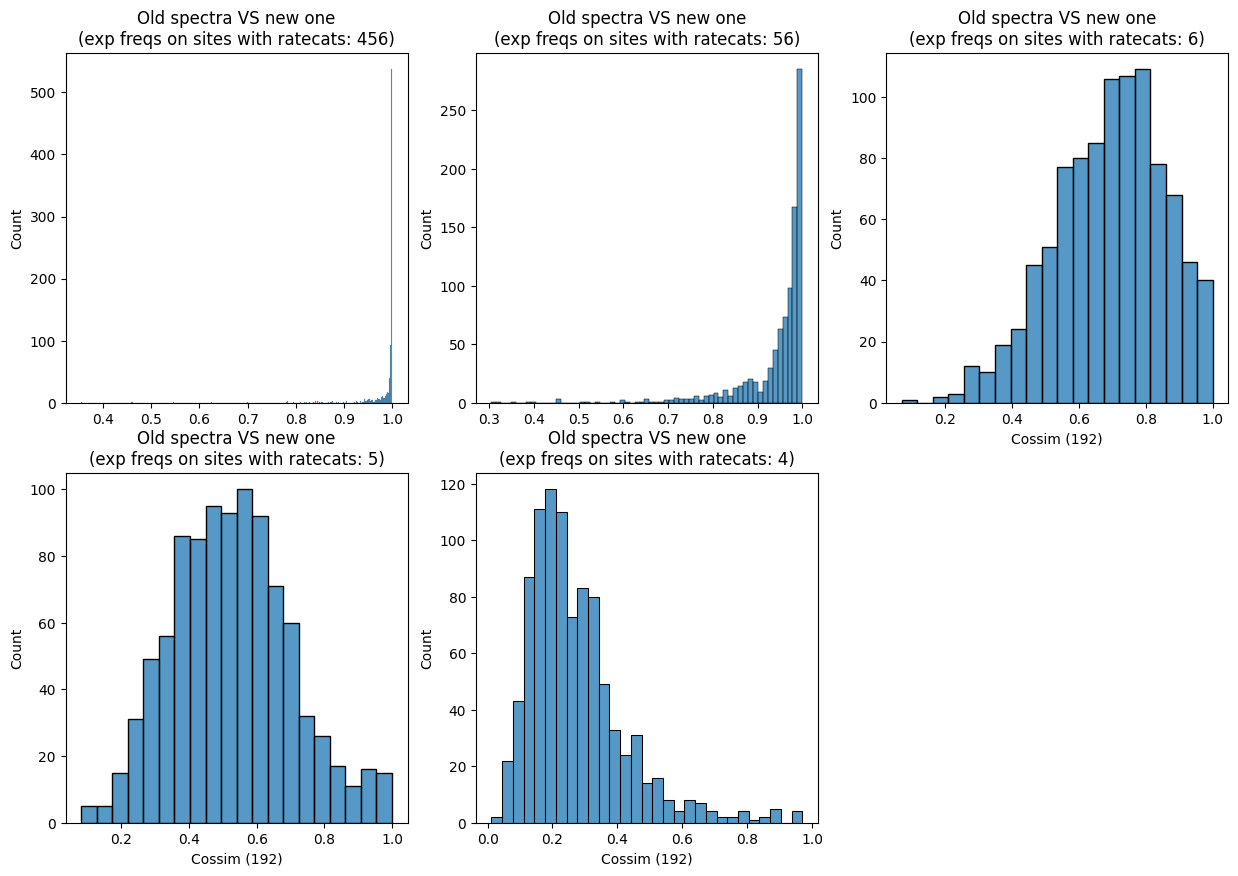

In [25]:
plt.figure(figsize=(15, 10))
for i, (new_spec, lbl) in enumerate(zip(
    [mutspec456, mutspec56, mutspec6, mutspec5, mutspec4], ['456', '56', '6', '5', '4']),1):

    cossim = get_cossim(mutspec_old, new_spec)
    plt.subplot(2, 3, i)
    plt.title(f'Old spectra VS new one\n(exp freqs on sites with ratecats: {lbl})')
    if i > 2:
        plt.xlabel('Cossim (192)')
    sns.histplot(cossim)
plt.show()

Compare exp freqs on different ratecats of sites


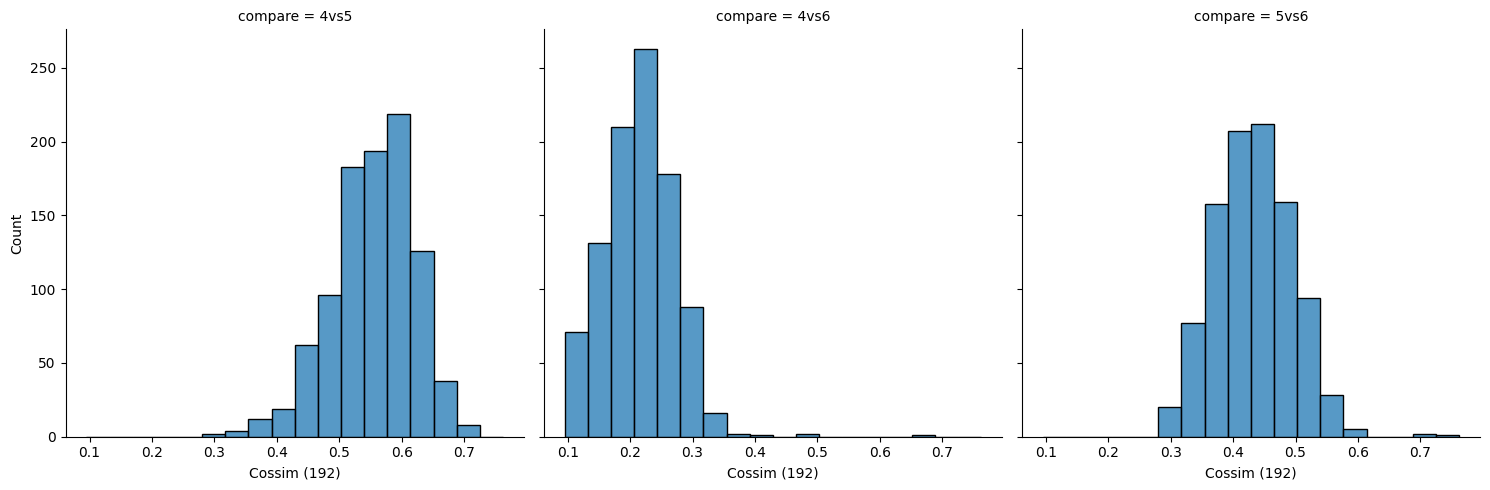

In [26]:
df = pd.concat([
    get_cossim(exp4, exp5).rename('Cossim (192)').reset_index().assign(compare='4vs5'),
    get_cossim(exp4, exp6).rename('Cossim (192)').reset_index().assign(compare='4vs6'),
    get_cossim(exp6, exp5).rename('Cossim (192)').reset_index().assign(compare='5vs6'),
], ignore_index=True)
print('Compare exp freqs on different ratecats of sites')
sns.displot(data=df, x='Cossim (192)', col='compare', col_wrap=3, kind='hist');

### All together

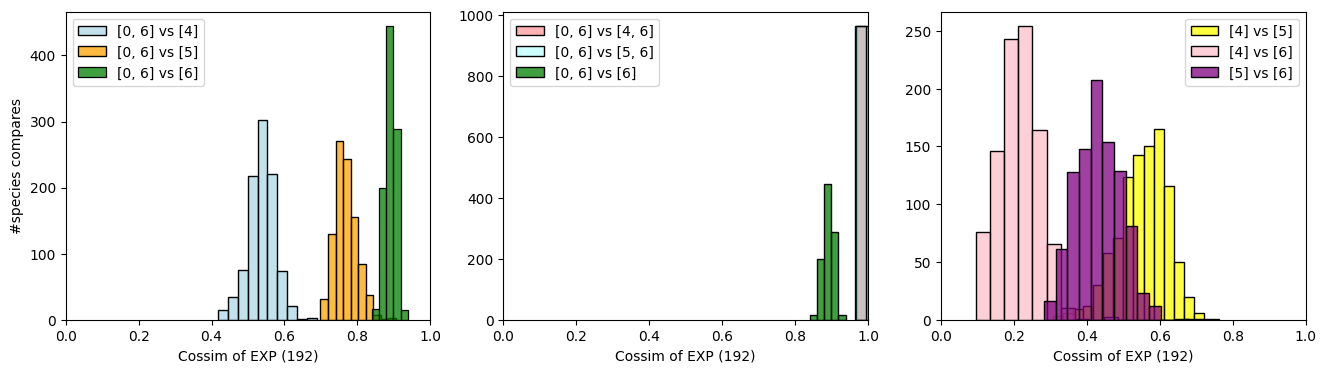

In [32]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(16, 4)

xlabel = 'Cossim of EXP (192)'

sns.histplot(get_cossim(exp_old, exp4).rename(xlabel), ax=axs[0], label='[0, 6] vs [4]', bins=10, color='lightblue')
sns.histplot(get_cossim(exp_old, exp5).rename(xlabel), ax=axs[0], label='[0, 6] vs [5]', bins=10, color='orange')
sns.histplot(get_cossim(exp_old, exp6).rename(xlabel), ax=axs[0], label='[0, 6] vs [6]', bins=5, color='green')

sns.histplot(get_cossim(exp_old, exp456).rename(xlabel), ax=axs[1], label='[0, 6] vs [4, 6]', bins=1, alpha=0.3, color='red')
sns.histplot(get_cossim(exp_old, exp56).rename(xlabel), ax=axs[1], label='[0, 6] vs [5, 6]', bins=1, alpha=0.2, color='cyan')
sns.histplot(get_cossim(exp_old, exp6).rename(xlabel), ax=axs[1], label='[0, 6] vs [6]', bins=5, color='green')

sns.histplot(get_cossim(exp4, exp5).rename(xlabel), ax=axs[2], label='[4] vs [5]', bins=15, color='yellow')
sns.histplot(get_cossim(exp4, exp6).rename(xlabel), ax=axs[2], label='[4] vs [6]', bins=15, color='pink')
sns.histplot(get_cossim(exp6, exp5).rename(xlabel), ax=axs[2], label='[5] vs [6]', bins=15, color='purple')

axs[0].set_ylabel('#species compares')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
for ax in axs:
    ax.set_xlim(0, 1)
    ax.legend()
plt.savefig('../pictures/exp_cossim_ratecat_related.pdf', bbox_inches='tight')
plt.savefig('../pictures/exp_cossim_ratecat_related.jpg', bbox_inches='tight')
plt.show()